### Generate empirical curve for prediction PV plant power output for controls ###

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import griddata

import pvlib
from pvlib import iotools, location
from pvlib.irradiance import get_total_irradiance
from pvlib.pvarray import pvefficiency_adr

In [5]:
os.chdir('/Users/bstanisl/hercules-pysam/hercules')

In [2]:
PVLIB_DIR = pvlib.__path__[0]
DATA_FILE = os.path.join(PVLIB_DIR, 'data', '723170TYA.CSV')
tmy, metadata = iotools.read_tmy3(DATA_FILE, coerce_year=1990,
                                  map_variables=True)

# DATA_FILE = '/Users/bstanisl/SAM Downloaded Weather Files/39.74_-105.17_psm3-tmy_60_tmy-2020.csv'
# tmy, metadata = iotools.read_tmy3(DATA_FILE, coerce_year=2020,
#                                   map_variables=True)

df = pd.DataFrame({'ghi': tmy['ghi'], 'dhi': tmy['dhi'], 'dni': tmy['dni'],
                   'temp_air': tmy['temp_air'],
                   'wind_speed': tmy['wind_speed'],
                   })

In [3]:
df.index = df.index - pd.Timedelta(minutes=30)

loc = location.Location.from_tmy(metadata)
solpos = loc.get_solarposition(df.index)

In [ ]:
TILT = metadata['latitude']
ORIENT = 180

total_irrad = get_total_irradiance(TILT, ORIENT,
                                   solpos.apparent_zenith, solpos.azimuth,
                                   df.dni, df.ghi, df.dhi)

df['poa_global'] = total_irrad.poa_global

In [ ]:
df['temp_pv'] = pvlib.temperature.faiman(df.poa_global, df.temp_air,
                                         df.wind_speed)

In [6]:

# reading csv file 
df = pd.read_csv("OK-TMY-100MW-singleaxistracking.csv")
df = df.rename(columns={'System power generated | (kW)': 'Power_kW',
    'Weather file ambient temperature | (C)': 'Air_temp_C',
    'Weather file wind speed | (m/s)': 'Wind_speed_mps',
    'Subarray 1 POA front total irradiance nominal | (W/m2)': 'Total_irradiance_Wm2'})

df

,Time stamp,Power_kW,Air_temp_C,Wind_speed_mps,Total_irradiance_Wm2
0,"Jan 1, 12:00 am",-12.2538,-3.3,5.8,0.0
1,"Jan 1, 12:30 am",-12.2538,-3.2,5.9,0.0
2,"Jan 1, 01:00 am",-12.2538,-3.0,6.0,0.0
3,"Jan 1, 01:30 am",-12.2538,-2.9,6.2,0.0
4,"Jan 1, 02:00 am",-12.2538,-2.8,6.3,0.0
...,...,...,...,...,...
17515,"Dec 31, 09:30 pm",-12.2538,-3.4,5.3,0.0
17516,"Dec 31, 10:00 pm",-12.2538,-3.3,5.4,0.0
17517,"Dec 31, 10:30 pm",-12.2538,-3.3,5.5,0.0
17518,"Dec 31, 11:00 pm",-12.2538,-3.4,5.6,0.0


In [7]:
df.columns

Index(['Time stamp', 'Power_kW', 'Air_temp_C', 'Wind_speed_mps',
       'Total_irradiance_Wm2'],
      dtype='object')

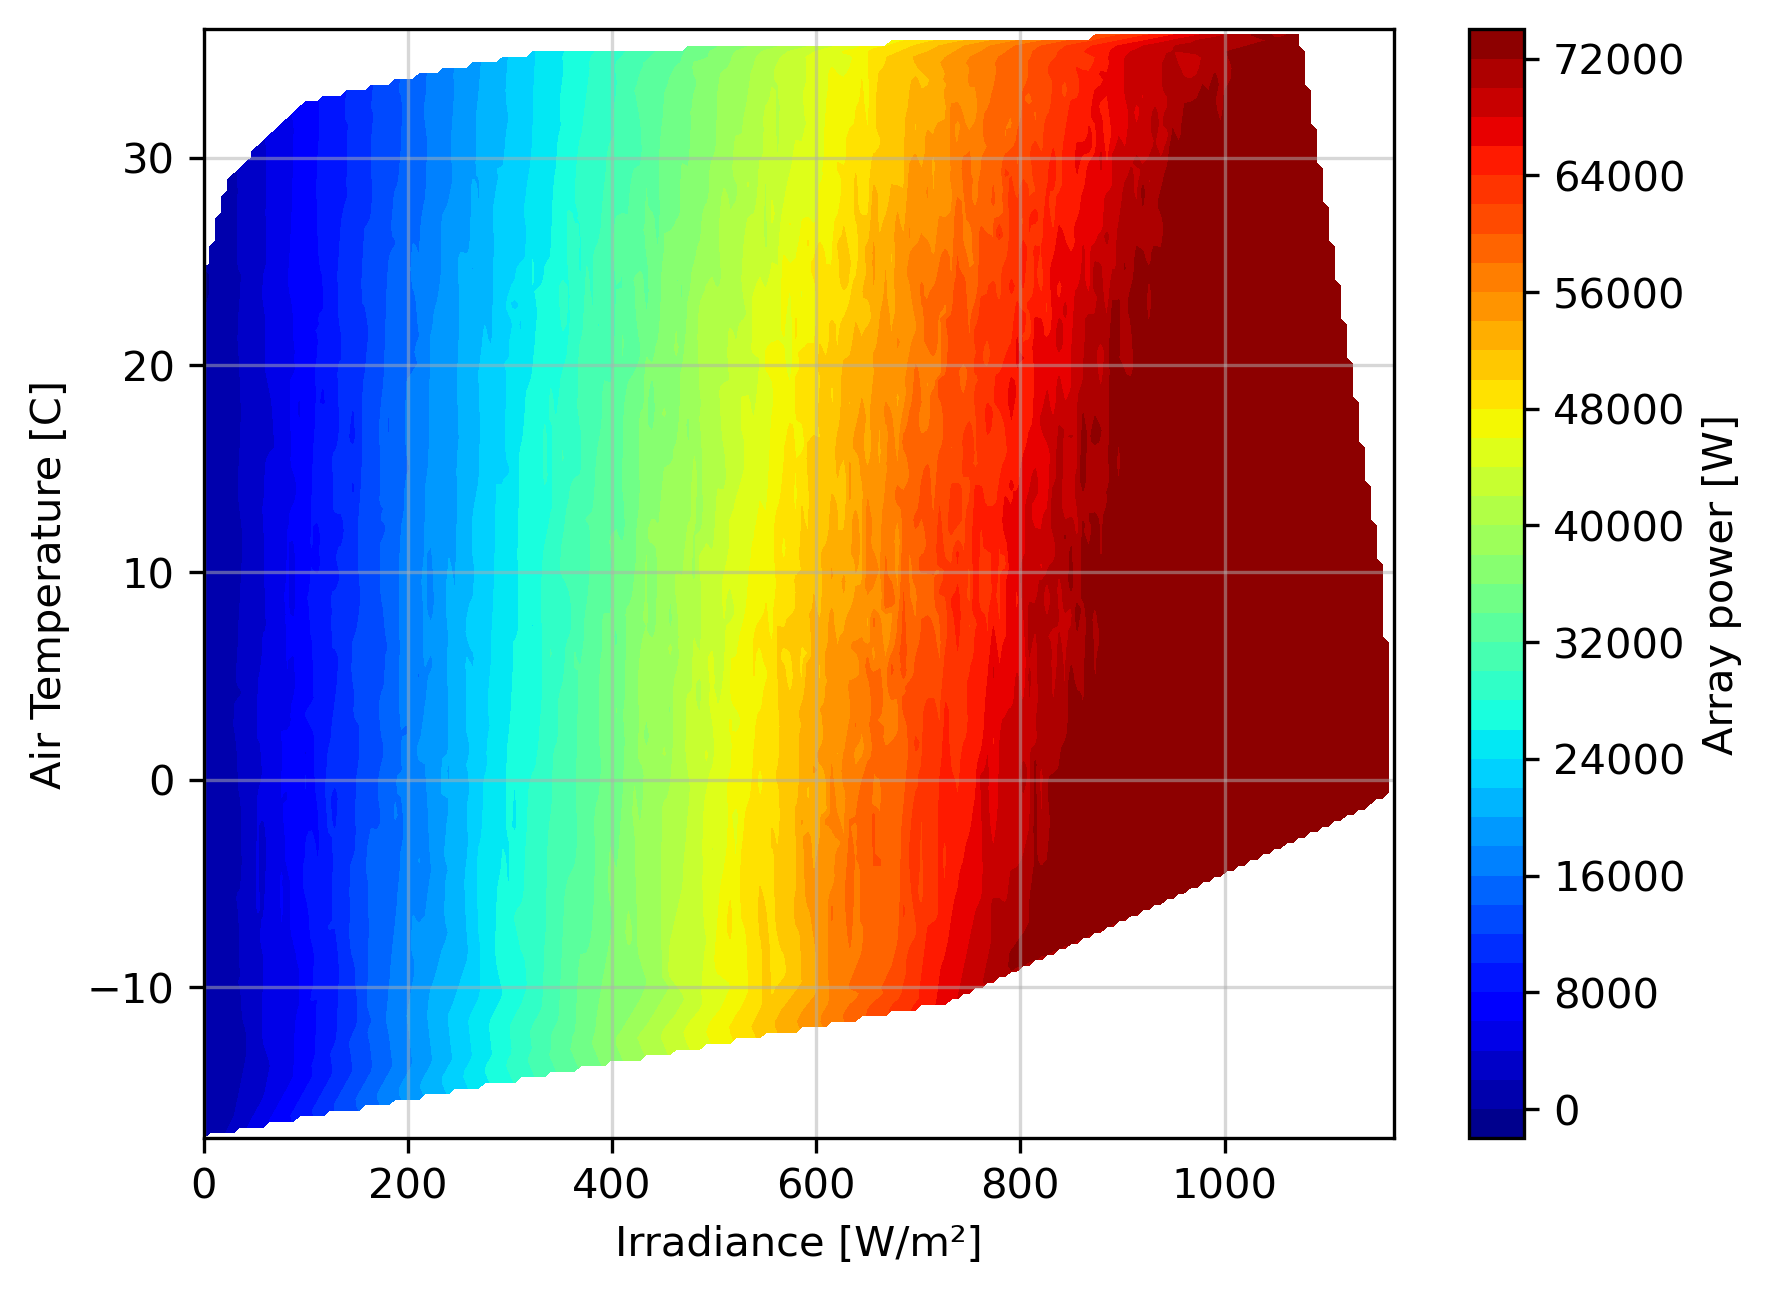

In [8]:
# interpolate onto a grid

x = df['Total_irradiance_Wm2'].values
y = df['Air_temp_C'].values
z = df['Power_kW'].values

xi = np.linspace(np.min(x), np.max(x), 200)
yi = np.linspace(np.min(y), np.max(y), 200)
zi = griddata((x,y), z, (xi[None,:], yi[:,None]), method='linear')

plt.figure(dpi=300)
plt.contourf(xi, yi, zi, 40, cmap='jet')

plt.colorbar(label='Array power [W]', ax=plt.gca())
# pc.set_alpha(0.25)
plt.grid(alpha=0.5)
plt.xlabel('Irradiance [W/m²]')
plt.ylabel('Air Temperature [C]')
plt.show()